In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.utils import resample
from torchmetrics import AUROC

%matplotlib inline

import logging

import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from torch.utils.data import DataLoader

In [4]:
torch.manual_seed(42)
random.seed(42)

In [6]:
df = pd.read_csv("WISDM_ar_v1.1_raw.txt", sep = ' ', header = None)

df['lenght'] = df[0].apply(lambda x: x.split(',')).apply(lambda x: len(x))
filtred_df = df[~df['lenght'].isin([7, 11])]
filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))

columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
for i, el in enumerate(columns):
  if i != len(columns)-1:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
  else:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i][:-1])

filtred_df = filtred_df.drop(columns = [0, 'lenght', 'timestamp'])

<ipython-input-6-e099350a8d69>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))
<ipython-input-6-e099350a8d69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
<ipython-input-6-e099350a8d69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [7]:
le = preprocessing.LabelEncoder()
filtred_df['activity'] = le.fit_transform(filtred_df['activity'])

In [8]:
filtred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086466 entries, 0 to 1098203
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   user      1086466 non-null  object
 1   activity  1086466 non-null  int64 
 2   x-axis    1086466 non-null  object
 3   y-axis    1086466 non-null  object
 4   z-axis    1086466 non-null  object
dtypes: int64(1), object(4)
memory usage: 49.7+ MB


In [9]:
def transform(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x


In [10]:
for el in filtred_df.columns:
  filtred_df[el] = filtred_df[el].apply(lambda x: transform(x))


In [11]:
for col in ['x-axis', 'y-axis', 'z-axis']:
  mean_value = filtred_df[col].mean()
  sigma = filtred_df[col].std()
  filtred_df[col] = filtred_df[col].apply(lambda x: (x-mean_value)/sigma)

In [12]:
unique_users = list(filtred_df["user"].unique())
random.shuffle(unique_users)

In [13]:
filtred_df['user'].value_counts()

20.0    56632
19.0    45383
31.0    44282
8.0     41188
29.0    38245
14.0    38192
13.0    37092
34.0    35947
32.0    35506
3.0     35161
27.0    34957
10.0    34883
18.0    32810
12.0    32641
26.0    32578
36.0    32261
11.0    31659
7.0     30967
1.0     29978
6.0     29704
33.0    29453
5.0     28509
15.0    28154
24.0    25736
23.0    25673
30.0    25334
21.0    23703
2.0     23525
35.0    22394
22.0    22310
17.0    22020
28.0    21358
16.0    20469
25.0    13468
9.0     12923
4.0     11371
Name: user, dtype: int64

In [14]:
def group_by_user(df, user):
  return df[df['user'] == user].reset_index(drop = True)

def create_window(df, overlay, window_size, train_x, train_y):
  for i in range(0, df.shape[0], overlay):
    df_sub = df.iloc[i:i+window_size]

    if df_sub.shape[0] == window_size:
      train_x.append(df_sub[['x-axis', 'y-axis', 'z-axis']].to_numpy())
      train_y.append(df_sub['activity'].mode().iloc[0])

  return train_x, train_y


train_x = []
train_y = []

window_size = 100
overlay = 50

users = unique_users[12:]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, train_x, train_y)

print (len(train_x), len(train_y))


15078 15078


In [15]:
test_x = []
test_y = []

users = unique_users[12:18]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, test_x, test_y)

print (len(test_x), len(test_y))


3775 3775


In [16]:
control_x = []
control_y = []

users = unique_users[18:22]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, control_x, control_y)

print (len(control_x), len(control_y))

2516 2516


In [17]:
import pickle

with open("train_x.pkl", "wb") as f:
    pickle.dump(train_x, f)

with open("train_y.pkl", "wb") as f:
    pickle.dump(train_y, f)

In [18]:
train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last = True)

test_dataset = TensorDataset(torch.tensor(test_x, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last = True)

<ipython-input-18-bab83bad87de>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))


In [19]:
control_dataset = TensorDataset(torch.tensor(control_x, dtype=torch.float32), torch.tensor(control_y, dtype=torch.float32))
control_loader = DataLoader(control_dataset, batch_size=128, shuffle=True, drop_last = True)

In [20]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.lstm1 = nn.LSTM(input_size = 3, hidden_size = 1024, bidirectional=True, batch_first=True)
    self.lstm2 = nn.LSTM(input_size = 2048, hidden_size = 768, bidirectional=True, batch_first=True)
    self.lstm3 = nn.LSTM(input_size = 3, hidden_size = 768, bidirectional=True, batch_first=True)
    self.lstm4 = nn.LSTM(input_size = 3072, hidden_size = 512, bidirectional=True, batch_first=True)
    self.lstm5 = nn.LSTM(input_size = 1536, hidden_size = 512, bidirectional=True, batch_first=True)
    self.global_max_pooling = torch.nn.Sequential(
    torch.nn.AdaptiveMaxPool1d(1),
    torch.nn.Flatten(),)
    self.dense_1 = nn.Linear(100, 128)
    self.dropout = nn.Dropout(0.05)
    self.dense_2 = nn.Linear(128, 6)
    self.dense_3 = nn.Softmax()

  def forward(self, inputs):
        x1, _ = self.lstm1(inputs)
        l1, _ = self.lstm2(x1)
        l2, _ = self.lstm3(inputs)
        c1 = torch.cat((l1, l2), dim=2)

        l3, _ = self.lstm4(c1)
        l4, _ = self.lstm5(l2)

        c2 = torch.cat((l3, l4), dim=2)
        l6 = self.global_max_pooling(c2)
        l7 = self.dense_1(l6)
        l8 = self.dropout(l7)

        output = self.dense_2(l8)
        output = self.dense_3(output)

        return output

In [21]:
for inputs, labels in train_loader:
  print (inputs.shape, labels.shape)
  break

torch.Size([128, 100, 3]) torch.Size([128])


In [22]:
logger = TensorBoardLogger("lightning_logs", name="surface_predictor")

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [24]:
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_labels)
    return accuracy

In [25]:
device

device(type='cuda', index=0)

In [26]:
import gc
train_losses = []
valid_losses = []
def train():
    running_loss = torch.tensor(0.0, device=device)
    y_true = []
    y_pred_probs = []
    model.train()

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        running_loss += loss

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.cpu().detach().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_loss {train_loss}, train_accuracy {accuracy}')
    return train_losses

def valid():
    running_loss = torch.tensor(0.0, device=device)
    y_true = []
    y_pred_probs = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs.float())
            loss = criterion(preds, labels.squeeze().long())

            if not loss.isnan():
              running_loss += loss

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(preds.detach().cpu().numpy())

        valid_loss = running_loss/(i+1)
        valid_losses.append(valid_loss.cpu().detach().numpy())

        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs)
        accuracy = calculate_accuracy(y_true, y_pred_probs)

        print(f'validation_loss {valid_loss}, validation_accuracy {accuracy}')
    return valid_losses, accuracy

epochs = 20
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    train_losses = train()
    valid_losses, _ = valid()
    gc.collect()

epochs 1/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.764297366142273, train_accuracy 0.3229166666666667


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 8.31575870513916, validation_accuracy 0.34132543103448276
epochs 2/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.7037321329116821, train_accuracy 0.36525106837606836


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 8.132353782653809, validation_accuracy 0.36584051724137934
epochs 3/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6764503717422485, train_accuracy 0.3760016025641026


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 8.060481071472168, validation_accuracy 0.3642241379310345
epochs 4/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6647672653198242, train_accuracy 0.37573450854700857


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 8.023639678955078, validation_accuracy 0.3644935344827586
epochs 5/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6562589406967163, train_accuracy 0.3762686965811966


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.945340156555176, validation_accuracy 0.36584051724137934
epochs 6/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6316441297531128, train_accuracy 0.37693643162393164


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.780843734741211, validation_accuracy 0.36691810344827586
epochs 7/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6198031902313232, train_accuracy 0.3761351495726496


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.750331401824951, validation_accuracy 0.36691810344827586
epochs 8/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6142204999923706, train_accuracy 0.3762686965811966


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.741397857666016, validation_accuracy 0.3636853448275862
epochs 9/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6099966764450073, train_accuracy 0.3770032051282051


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.706725120544434, validation_accuracy 0.3644935344827586
epochs 10/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.60728120803833, train_accuracy 0.3770032051282051


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.685798168182373, validation_accuracy 0.3655711206896552
epochs 11/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6054744720458984, train_accuracy 0.3767361111111111


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.661480903625488, validation_accuracy 0.3644935344827586
epochs 12/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6031345129013062, train_accuracy 0.3761351495726496


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.634360313415527, validation_accuracy 0.3655711206896552
epochs 13/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.6001884937286377, train_accuracy 0.3758680555555556


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.59523344039917, validation_accuracy 0.36637931034482757
epochs 14/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.5918207168579102, train_accuracy 0.37593482905982906


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.557435512542725, validation_accuracy 0.36314655172413796


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


epochs 15/20
train_loss 1.5792466402053833, train_accuracy 0.3766025641025641


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.530404090881348, validation_accuracy 0.3793103448275862
epochs 16/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.5639870166778564, train_accuracy 0.44003739316239315


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.419145584106445, validation_accuracy 0.5695043103448276
epochs 17/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.5352106094360352, train_accuracy 0.6111778846153846


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.294015407562256, validation_accuracy 0.6470905172413793
epochs 18/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.498927354812622, train_accuracy 0.6438301282051282


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 7.105536937713623, validation_accuracy 0.6460129310344828
epochs 19/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.4722011089324951, train_accuracy 0.641426282051282


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 6.955206871032715, validation_accuracy 0.6551724137931034
epochs 20/20


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 1.4462097883224487, train_accuracy 0.6488381410256411


<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 6.901148796081543, validation_accuracy 0.6454741379310345


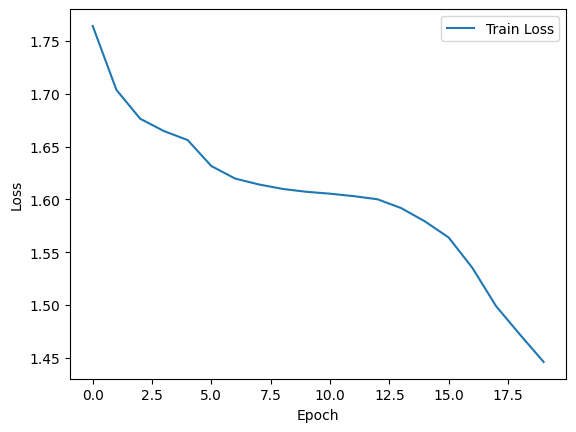

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

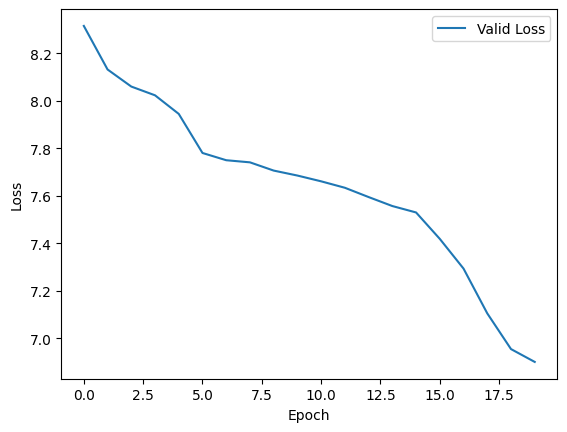

In [28]:
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
def after_argmax(y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    return y_pred_labels

In [30]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(control_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = [str(x) for x in range(0,6)]
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f' control_accuracy {accuracy}')

<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       211
           1       0.61      0.69      0.65       704
           2       0.88      0.99      0.93       173
           3       0.00      0.00      0.00       118
           4       0.00      0.00      0.00       221
           5       0.65      0.94      0.77      1005

    accuracy                           0.66      2432
   macro avg       0.36      0.44      0.39      2432
weighted avg       0.51      0.66      0.57      2432

 control_accuracy 0.6570723684210527


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = [str(x) for x in range(0,6)]
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'test_accuracy {accuracy}')

<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       312
           1       0.60      0.92      0.73      1261
           2       0.37      0.54      0.44       207
           3       0.00      0.00      0.00       212
           4       0.00      0.00      0.00       373
           5       0.76      0.84      0.80      1347

    accuracy                           0.65      3712
   macro avg       0.29      0.38      0.33      3712
weighted avg       0.50      0.65      0.56      3712

test_accuracy 0.6454741379310345


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = [str(x) for x in range(0,6)]
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_accuracy {accuracy}')

<ipython-input-20-ea2ba83ffe76>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1443
           1       0.68      0.86      0.76      4519
           2       0.68      0.80      0.73       932
           3       0.00      0.00      0.00       693
           4       0.00      0.00      0.00      1754
           5       0.64      0.92      0.75      5635

    accuracy                           0.66     14976
   macro avg       0.33      0.43      0.37     14976
weighted avg       0.49      0.66      0.56     14976

train_accuracy 0.6555154914529915


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
